# Moein Shirdel -- 810197535
## AI-CA5 - Phase 1

In [21]:
import numpy as np

# Dataloader

In [22]:
import random
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
        
    def get_onehot_labels(self):
        return self.__onehot_labels
    
    def __onehot(self, labels, n_classes):
        one_hot_targets = np.eye(self.__n_classes)[labels]
        return np.squeeze(one_hot_targets, axis=1)
    
    def __shuffle_dataset(self):
        order = np.random.permutation(len(self.__data))
        self.__data = self.__data[order]
        self.__onehot_labels = self.__onehot_labels[order]
        
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [23]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        temp = np.matrix(matrix, dtype = float)
        relu_value = np.where(temp > 0, temp, 0)
        return relu_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype = float)
        relu_derivative_value = np.where(temp > 0, 1, 0)
        return relu_derivative_value
    
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        leaky_relu_value = np.where(temp > 0, temp, temp * self.negative_slope)
        return leaky_relu_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        leaky_relu_derivative = np.where(temp > 0, 1, self.negative_slope)
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = (-1) * np.matrix(matrix, dtype=float)
        sigmoid_value = 1/(1 + np.exp((temp)))
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_derivative = np.matrix(np.array(self.__val(matrix)) * np.array(1 - self.__val(matrix)),dtype=float) 
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        temp = temp - temp.max()
        softmax_value = np.exp(temp) / np.sum(np.exp(temp)) 
        return softmax_value

    def __call__(self, matrix):
        return self.__val(matrix)
    

# Loss Function

In [24]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        SM = Softmax()
        softmax_out = np.matrix(true_val)
        for i in range(len(true_val)):
            softmax_out[i] = SM(true_val[i])
        cross_entropy_value = np.matrix(- np.array(expected_val) * np.log(np.array(softmax_out + 1e-9))
                                               ,dtype=float)
        
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        SM = Softmax()
        softmax_out = np.matrix(true_val)
        for i in range(len(true_val)):
            softmax_out[i] = SM(true_val[i])
        cross_entropy_derivative = softmax_out - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [25]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        

    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        self.__last_input = np.matrix(layer_input)
        self.__last_activation_input = (self.__last_input * self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        W_tr = np.matrix(self.__weight)
        W_tr = W_tr.transpose()
        X_tr = self.__last_input.transpose()
        ones = np.ones(np.shape(self.__last_input), dtype = float)
        ones_tr = ones.transpose()
        
        dL_dA = np.matrix((np.array(backprop_tensor) * np.array(self.__last_activation_derivative)), dtype = float)
        dL_dW = X_tr * dL_dA
        dL_dB = np.sum(dL_dA, axis=0)
        
        self.__weight = self.__weight - lr * dL_dW
        self.__bias = self.__bias - lr * dL_dB
#         print("Layer weights: ")
#         print(self.__weight)
        backprop_tensor = dL_dA * W_tr
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low, high, (dim1, dim2)) 
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.random.normal(mean, np.sqrt(var), (dim1, dim2))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [26]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
            
    def get_2Dout(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        for i in range(len(self.__layers_list)):
            if i == 0:
                layer_result = self.__layers_list[i].forward(network_input)
            else:
                layer_result = self.__layers_list[i].forward(layer_result)
            if i == len(self.__layers_list) - 2:
                return layer_result
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        for i in range(len(self.__layers_list)):
            if i == 0:
                layer_result = self.__layers_list[i].forward(network_input)
            else:
                layer_result = self.__layers_list[i].forward(layer_result)
        
        network_output = layer_result
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        
        back = self.forward(x_batch)
        last_layer_output = self.__get_labels(back)
        self.__update_weights(back, y_batch)
        batch_accuracy = self.__compute_accuracy(last_layer_output, y_batch)
        CE = CrossEntropy()
        batch_whole_loss = CE(last_layer_output, y_batch)
        batch_average_loss = sum(batch_whole_loss) / len(batch_whole_loss)
        
        return (batch_accuracy, batch_average_loss)

        
    def __test_on_batch(self, x_batch, y_batch):
        
        last_layer_output = self.forward(x_batch)
        last_layer_output = self.__get_labels(last_layer_output)
        batch_accuracy = self.__compute_accuracy(last_layer_output, y_batch)
        CE = CrossEntropy()
        batch_whole_loss = CE(last_layer_output, y_batch)
        batch_average_loss = sum(batch_whole_loss) / len(batch_whole_loss)
        
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        labels = outputs
        for i in range(len(outputs)):
            index = np.argmax(outputs[i])
            for j in range(len(outputs[i])):
                if(j == index):
                    labels[i,j] = 1.
                else:
                    labels[i,j] = 0.

        labels = np.matrix(labels)
        return labels
    
    def __compute_accuracy(self, output, expected_output):
        correct = 0
        index = 0
        for expected_label in expected_output:
            predicted_label = output[index]
            if(np.argmax(predicted_label) == np.argmax(expected_label)):
                correct += 1
            index += 1
        accuracy = correct / len(output) 
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        backprop_tensor = CrossEntropy().derivative(output, y_train)
        for i in range(len(self.__layers_list) - 1, -1, -1):
            backprop_tensor = self.__layers_list[i].update_weights(backprop_tensor, self.__lr)
            
        return

# Training Sample Code

In [27]:
# Sample code for building and training a model
def data_preprocessor(data):
    data = np.matrix(data)
    data = data / 256
    return data
    
def label_preprocessor(labels):
    labels = np.matrix(labels)
    labels = labels.transpose()
    
    return labels

INPUT_SHAPE = 784
LEARNING_RATE = 0.0001
EPOCHS = 30
BATCH_SIZE = 32

train_data = np.genfromtxt('./Fashion-MNIST/trainData.csv', delimiter=',')
train_labels = np.genfromtxt('./Fashion-MNIST/trainLabels.csv', delimiter=',', dtype = int)
test_data = np.genfromtxt('./Fashion-MNIST/testData.csv', delimiter=',')
test_labels = np.genfromtxt('./Fashion-MNIST/testLabels.csv', delimiter=',', dtype = int)



In [28]:

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.2903	Average Loss: 0.18377452298984032
	Test: Average Accuracy: 0.47653753993610226	Average Loss: 0.1348980291872519
Epoch 2:
	Train: Average Accuracy: 0.59885	Average Loss: 0.11454449751357636
	Test: Average Accuracy: 0.6561501597444089	Average Loss: 0.09738756311296334
Epoch 3:
	Train: Average Accuracy: 0.6837	Average Loss: 0.08593858817080884
	Test: Average Accuracy: 0.6924920127795527	Average Loss: 0.08064018206033857
Epoch 4:
	Train: Average Accuracy: 0.7253333333333334	Average Loss: 0.07468171335182307
	Test: Average Accuracy: 0.7322284345047924	Average Loss: 0.07316660057694017
Epoch 5:
	Train: Average Accuracy: 0.7566666666666667	Average Loss: 0.0679543551591154
	Test: Average Accuracy: 0.7584864217252396	Average Loss: 0.06704808136285832
Epoch 6:
	Train: Average Accuracy: 0.7781666666666667	Average Loss: 0.06278334791670526
	Test: Average Accuracy: 0.7718650159744409	Average Loss: 0.06283833736385856
Epoch 7:
	Train: Average Accuracy: 0.796

# Report:

##### The whole network has been designed with the codes above. I've added the things needed for the report.

### Level 1: Data Preprocessing

1- Showing a record (data row) from the dataset for each class:
The first data row of each class has been printed (as an example) using the code below.

In [29]:
NUMBER_OF_CLASSES = 10
is_shown = [False for x in range(NUMBER_OF_CLASSES)]
printed = 0
for i in range(len(train_labels)):
    if(printed == NUMBER_OF_CLASSES):
        break
    if is_shown[train_labels[i]]:
        continue
    else:
        print("Example for class number %d:"% train_labels[i])
        print(train_data[i], "\n\n")
        is_shown[train_labels[i]] = True
        printed += 1

Example for class number 9:
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
   0.  13.  73.   0.   0.   1.   4.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.
  36. 136. 127.  62.  54.   0.   0.   0.   1.   3.   4.   0.   0.   3.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   0.
 102. 204. 176. 134. 144. 123.  23.   0.   0.   0.   0.  12.  10.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 155. 236. 207. 178. 107. 156. 161. 109.  64.  23

2- As drawn below, the frequency of the labels are equal in test labels and train data labels.

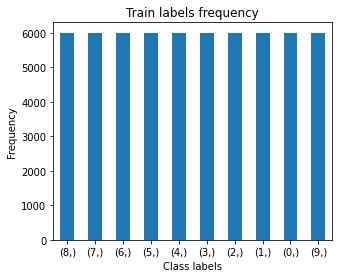

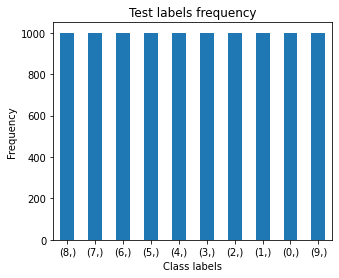

In [30]:
import matplotlib.pyplot as mtplot
import pandas as pd

train_lab = pd.read_csv("./Fashion-MNIST/trainLabels.csv", dtype=int)
test_lab = pd.read_csv("./Fashion-MNIST/testLabels.csv", dtype=int)
train_lab.value_counts().plot(kind='bar', figsize=(5, 4), rot=0)
mtplot.title("Train labels frequency");
mtplot.xlabel("Class labels")
mtplot.ylabel("Frequency")
mtplot.show()
test_lab.value_counts().plot(kind='bar', figsize=(5, 4), rot=0)
mtplot.title("Test labels frequency");
mtplot.xlabel("Class labels")
mtplot.ylabel("Frequency")
mtplot.show()

3- The process of normalizing train data has been done in the data_processor() function. It scales the values to the (0, 1) range because working with big values such as 220 or 250 causes overflow in neural network calculations. The advantage of using this function is to avoid overflow.

### Level 2: Completing missing codes
This part has been done and the complete code sections and their sample results have been placed at the top of this page.


### Level 3: Data Classification

#### Step 1: 
The sample output of the neural network which has been printed above, is the result of running the network with learning_rate = 0.0001, number_of_epochs = 30, and batch_size = 32, these values where the most efficient ones.

#### Step 2: In the following sections, learning rate value is changed to 0.00001 and 0.001
Changing Learning rate from 0.0001 to 0.00001: As the learning is too slow, the first epochs have not been classifiend accurately but after those first ones, the accuracy of the network's classification becomes reasonable but still it is below 70%. So 0.00001 is not appropriate for learning rate.


In [31]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.00001
EPOCHS = 30
BATCH_SIZE = 32

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.10845	Average Loss: 0.2317605788915158
	Test: Average Accuracy: 0.10473242811501597	Average Loss: 0.2270036975999074
Epoch 2:
	Train: Average Accuracy: 0.1169	Average Loss: 0.2256467098117353
	Test: Average Accuracy: 0.11331869009584665	Average Loss: 0.2238369516334139
Epoch 3:
	Train: Average Accuracy: 0.13051666666666667	Average Loss: 0.22040215673622568
	Test: Average Accuracy: 0.10912539936102236	Average Loss: 0.21607749593640155
Epoch 4:
	Train: Average Accuracy: 0.21553333333333333	Average Loss: 0.20839589322941776
	Test: Average Accuracy: 0.26677316293929715	Average Loss: 0.19968989244836133
Epoch 5:
	Train: Average Accuracy: 0.3287833333333333	Average Loss: 0.18911493837022678
	Test: Average Accuracy: 0.35493210862619806	Average Loss: 0.17909305956751564
Epoch 6:
	Train: Average Accuracy: 0.38838333333333336	Average Loss: 0.16980197757874052
	Test: Average Accuracy: 0.4326078274760383	Average Loss: 0.16194418706470173
Epoch 7:
	Train: Averag

-- Changing Learning rate from 0.0001 to 0.001: Based on the results printed below, it seems that 0.001 is doing better than 0.0001 since we've got better accuracy.

##### So the Learning Rate value will be changed to 0.001.

In [32]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 32

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6805333333333333	Average Loss: 0.08921194554182095
	Test: Average Accuracy: 0.8052116613418531	Average Loss: 0.05706358157845523
Epoch 2:
	Train: Average Accuracy: 0.8239666666666666	Average Loss: 0.05085467006566701
	Test: Average Accuracy: 0.8226837060702875	Average Loss: 0.05094052001076687
Epoch 3:
	Train: Average Accuracy: 0.8417833333333333	Average Loss: 0.045755845069567244
	Test: Average Accuracy: 0.8398562300319489	Average Loss: 0.04634198408420854
Epoch 4:
	Train: Average Accuracy: 0.8504	Average Loss: 0.043316722885130145
	Test: Average Accuracy: 0.8398562300319489	Average Loss: 0.04588548163258225
Epoch 5:
	Train: Average Accuracy: 0.8540333333333333	Average Loss: 0.04171548629280199
	Test: Average Accuracy: 0.8357627795527156	Average Loss: 0.048614660011852405
Epoch 6:
	Train: Average Accuracy: 0.8576	Average Loss: 0.04059828998684979
	Test: Average Accuracy: 0.84375	Average Loss: 0.04566018272006286
Epoch 7:
	Train: Average Accuracy: 0

#### Step 3: Changing the activation function of first layer
The first sample result belongs to Relu() function. Sigmoid and LeakyRelu() are tested in following code sections.

-- Testing LeakyRelu() activation function:

In [33]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 32

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.68935	Average Loss: 0.08729812871050333
	Test: Average Accuracy: 0.7924321086261981	Average Loss: 0.061291102029256424
Epoch 2:
	Train: Average Accuracy: 0.8260666666666666	Average Loss: 0.05006605019322643
	Test: Average Accuracy: 0.8211861022364217	Average Loss: 0.05069155857774517
Epoch 3:
	Train: Average Accuracy: 0.8412833333333334	Average Loss: 0.04547918101048267
	Test: Average Accuracy: 0.8185902555910544	Average Loss: 0.04938487796791863
Epoch 4:
	Train: Average Accuracy: 0.8496333333333334	Average Loss: 0.043057794193646734
	Test: Average Accuracy: 0.8256789137380192	Average Loss: 0.04816736406621305
Epoch 5:
	Train: Average Accuracy: 0.8527333333333333	Average Loss: 0.041646556985964804
	Test: Average Accuracy: 0.8444488817891374	Average Loss: 0.04388503798981531
Epoch 6:
	Train: Average Accuracy: 0.85695	Average Loss: 0.04040554001676133
	Test: Average Accuracy: 0.8469448881789138	Average Loss: 0.043132688258249535
Epoch 7:
	Train: Avera

-- Testing Sigmoid() activation function:

In [34]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 32

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.12446666666666667	Average Loss: 0.2294295612335246
	Test: Average Accuracy: 0.20996405750798722	Average Loss: 0.21503369064450392
Epoch 2:
	Train: Average Accuracy: 0.34701666666666664	Average Loss: 0.1760961428152356
	Test: Average Accuracy: 0.5208666134185304	Average Loss: 0.1444681616868189
Epoch 3:
	Train: Average Accuracy: 0.54195	Average Loss: 0.12423503964541967
	Test: Average Accuracy: 0.6207068690095847	Average Loss: 0.10930745540160194
Epoch 4:
	Train: Average Accuracy: 0.6877833333333333	Average Loss: 0.09577685438270736
	Test: Average Accuracy: 0.7112619808306709	Average Loss: 0.08647526293208087
Epoch 5:
	Train: Average Accuracy: 0.7341833333333333	Average Loss: 0.07910656957805963
	Test: Average Accuracy: 0.733326677316294	Average Loss: 0.07511026260635931
Epoch 6:
	Train: Average Accuracy: 0.7495333333333334	Average Loss: 0.06987477312199693
	Test: Average Accuracy: 0.7496006389776357	Average Loss: 0.06828833826051858
Epoch 7:
	Train:

I) The advantage of Leaky ReLU over normal ReLU: normal ReLU return a constant 0 value for negative inputs which are known as dead values and may block the learning process in some networks since in the back-propagation phase (which updates the weights), the derivative for negative values is 0 and this, stops the learning progress if we don't handle the negative values. 

II) The network which uses sigmoid function has the maximum accuracy of 83% which is a bit less than other activation functions. One major benefit of ReLU (and LeakyReLU) over Sigmoid is the reduced likelihood of the gradient to vanish. When a (input of activation function) is positive, the gradient has a constant value. In contrast, the gradient of sigmoids becomes increasingly small as the absolute value of x increases. The constant gradient of ReLUs results in faster learning. The other benefit of ReLUs is sparsity which arises when a is negative. The more such units that exist in a layer the more sparse the resulting representation. Sigmoids on the other hand are always likely to generate some non-zero value resulting in dense representations, since sparse representations seem to be more beneficial than dense representations.

##### According to the printed accuracies, LeakyReLU and ReLU have done a bit better than Sigmoid. Thus LeakyReLU is chosen for the chosen activation function in the following code sections.

#### Step 4: Changing the batch size
In the first sample result, each batch contains 32 rows of data. It will be changed and tested in the following sections. Large batch size means the model makes very large gradient updates. The size of the update depends heavily on which particular samples are drawn from the dataset. On the other hand using small batch size means the model makes updates that are all about the same size. The size of the update only weakly depends on which particular samples are drawn from the dataset.

-- Testing BATCH_SIZE=128 on the network: As it's obvious, we can not achieve a high accuracy using larger batch size.

In [35]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 128

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.4337519989339019	Average Loss: 0.17017457272804917
	Test: Average Accuracy: 0.5851463607594937	Average Loss: 0.12416653896999602
Epoch 2:
	Train: Average Accuracy: 0.6409470504619759	Average Loss: 0.10088967807335435
	Test: Average Accuracy: 0.6782041139240507	Average Loss: 0.08932963792640902
Epoch 3:
	Train: Average Accuracy: 0.6916866560056859	Average Loss: 0.08584120212959473
	Test: Average Accuracy: 0.7018393987341772	Average Loss: 0.08532283785408169
Epoch 4:
	Train: Average Accuracy: 0.7182336087420043	Average Loss: 0.08056192233203381
	Test: Average Accuracy: 0.7224090189873418	Average Loss: 0.08265192963163151
Epoch 5:
	Train: Average Accuracy: 0.7449360341151386	Average Loss: 0.07554799677249571
	Test: Average Accuracy: 0.7586036392405063	Average Loss: 0.07292007242365424
Epoch 6:
	Train: Average Accuracy: 0.7718716684434968	Average Loss: 0.07000996179397864
	Test: Average Accuracy: 0.7666139240506329	Average Loss: 0.07072139930383108
Epoc

-- Testing BATCH_SIZE=16 on the network: It seems that with a smaller value for batch size, a better accuracy is achievable and the network is giving better results. But the point is that very small batch sizes are not appropriate because the weights might take considerable changes.

##### There is not a big difference in accuracy using 16 and 32 values for BATCH_SIZE. So it will remain 32.

In [36]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 16

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6788	Average Loss: 0.08785681183674342
	Test: Average Accuracy: 0.8002	Average Loss: 0.05747391769495622
Epoch 2:
	Train: Average Accuracy: 0.8219833333333333	Average Loss: 0.05083169156562495
	Test: Average Accuracy: 0.829	Average Loss: 0.04915699129047312
Epoch 3:
	Train: Average Accuracy: 0.8415	Average Loss: 0.04569744300515685
	Test: Average Accuracy: 0.835	Average Loss: 0.04688949909988515
Epoch 4:
	Train: Average Accuracy: 0.8473666666666667	Average Loss: 0.04341992738509648
	Test: Average Accuracy: 0.8398	Average Loss: 0.045764563062228245
Epoch 5:
	Train: Average Accuracy: 0.85275	Average Loss: 0.04189016665547729
	Test: Average Accuracy: 0.8484	Average Loss: 0.043559628588055774
Epoch 6:
	Train: Average Accuracy: 0.8575833333333334	Average Loss: 0.04088522219477235
	Test: Average Accuracy: 0.8318	Average Loss: 0.04755807801169681
Epoch 7:
	Train: Average Accuracy: 0.8596333333333334	Average Loss: 0.04003358091751618
	Test: Average Accuracy

#### Step 5: The best number of epochs and overfitting

Each epoch that we give to the network is a single round of optimization. With more rounds of optimization, the error on training data will reduce further and further. But the point is that the network may become overfitted to the training data and will start to lose performance after a while.
As we can see in the drawn plots, after the 10th epoch, the results have not got better and it seems thay EPOCHS = 10 is an appropriate value to avoid over-fitting and under-fitting.

Epoch 1:
	Train: Average Accuracy: 0.6793666666666667	Average Loss: 0.08946084950997096
	Test: Average Accuracy: 0.8039137380191693	Average Loss: 0.057939594739875436
Epoch 2:
	Train: Average Accuracy: 0.8225666666666667	Average Loss: 0.05115256241894467
	Test: Average Accuracy: 0.8316693290734825	Average Loss: 0.04854711001825458
Epoch 3:
	Train: Average Accuracy: 0.8427833333333333	Average Loss: 0.045722330243376234
	Test: Average Accuracy: 0.770367412140575	Average Loss: 0.062389169176926586
Epoch 4:
	Train: Average Accuracy: 0.8487666666666667	Average Loss: 0.04358125037749141
	Test: Average Accuracy: 0.8441493610223643	Average Loss: 0.04480576065287061
Epoch 5:
	Train: Average Accuracy: 0.8527	Average Loss: 0.04212799625238813
	Test: Average Accuracy: 0.8406549520766773	Average Loss: 0.04479591857726696
Epoch 6:
	Train: Average Accuracy: 0.8561333333333333	Average Loss: 0.041254335536257306
	Test: Average Accuracy: 0.8401557507987221	Average Loss: 0.04506507546414388
Epoch 7:
	Tra

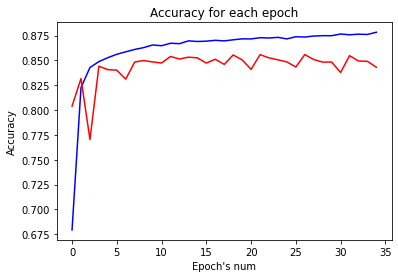

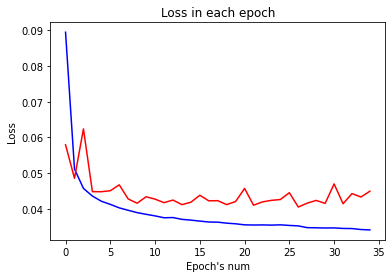

In [37]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 35
BATCH_SIZE = 32

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

# Plots

x_axis = [i for i in range(EPOCHS)]
mtplot.plot(x_axis, log['train_accuracy'], color="blue")
mtplot.plot(x_axis, log['test_accuracy'], color="red")
mtplot.title("Accuracy for each epoch")
mtplot.xlabel("Epoch's num")
mtplot.ylabel("Accuracy")
mtplot.show()

x_axis = [i for i in range(EPOCHS)]
mtplot.plot(x_axis, log['train_loss'], color="blue")
mtplot.plot(x_axis, log['test_loss'], color="red")
mtplot.title("Loss in each epoch")
mtplot.xlabel("Epoch's num")
mtplot.ylabel("Loss")
mtplot.show()

### Level 4: Reduced dimension method

* For this part, a method named "get_2Dout" has been defined which is called after the network gets trained and it will get the whole input and returns the output of the 2-neuron layer.

* Besides, a new network is trained below with different layers and hyper-parameters which has reached the minimum-accuracy(75%) at the last epochs. So it is used to get the 2D output.

In [38]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.0025
EPOCHS = 25
BATCH_SIZE = 32

norm_train_data = data_preprocessor(train_data.copy())
norm_test_data = data_preprocessor(test_data.copy())
norm_train_labels = label_preprocessor(train_labels.copy())
norm_test_labels = label_preprocessor(test_labels.copy())

TRAINLOADER = Dataloader(norm_train_data, norm_train_labels, 10, batch_size=BATCH_SIZE, shuffle=False)
TESTLOADER = Dataloader(norm_test_data, norm_test_labels, 10, batch_size=BATCH_SIZE, shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(784, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 0.18733333333333332	Average Loss: 0.2260717076846167
	Test: Average Accuracy: 0.25179712460063897	Average Loss: 0.18498079815230545
Epoch 2:
	Train: Average Accuracy: 0.3518833333333333	Average Loss: 0.16574661233926546
	Test: Average Accuracy: 0.577076677316294	Average Loss: 0.11915787609063962
Epoch 3:
	Train: Average Accuracy: 0.6287833333333334	Average Loss: 0.10228599004173894
	Test: Average Accuracy: 0.65814696485623	Average Loss: 0.09438757830321087
Epoch 4:
	Train: Average Accuracy: 0.6796333333333333	Average Loss: 0.09065441986989892
	Test: Average Accuracy: 0.7071685303514377	Average Loss: 0.08360646776694873
Epoch 5:
	Train: Average Accuracy: 0.6916333333333333	Average Loss: 0.08324428912971915
	Test: Average Accuracy: 0.6988817891373802	Average Loss: 0.0803261933618978
Epoch 6:
	Train: Average Accuracy: 0.6965833333333333	Average Loss: 0.07817170512916276
	Test: Average Accuracy: 0.6974840255591054	Average Loss: 0.07889369008039959
Epoch 7

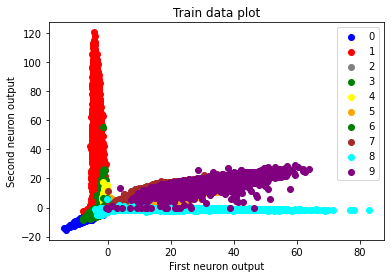

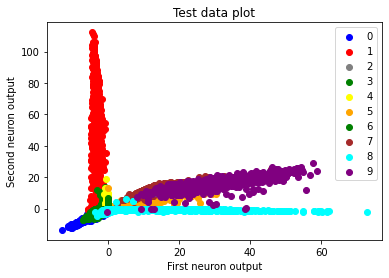

In [40]:
import matplotlib.pyplot as mtplot

NUMBER_OF_CLASSES = 10


def onehot_to_normal(labels):
    classes = []
    for row in labels:
        index = np.argmax(row)
        classes.append(index)
    return classes
    
layer2D_trainout = network.get_2Dout(norm_train_data)
layer2D_testout = network.get_2Dout(norm_test_data)

first_neuron_train = layer2D_trainout[:,0].tolist()
first_neuron_test = layer2D_testout[:,0].tolist()
second_neuron_train = layer2D_trainout[:,1].tolist()
second_neuron_test = layer2D_testout[:,1].tolist()

normal_train_labels = norm_train_labels.copy().tolist()
normal_test_labels = norm_test_labels.copy().tolist()

train_x_axis = [[] for i in range(NUMBER_OF_CLASSES)]
train_y_axis = [[] for i in range(NUMBER_OF_CLASSES)]
test_x_axis = [[] for i in range(NUMBER_OF_CLASSES)]
test_y_axis = [[] for i in range(NUMBER_OF_CLASSES)]

for i in range(len(normal_train_labels)):
    train_x_axis[normal_train_labels[i][0]].append(first_neuron_train[i])
    train_y_axis[normal_train_labels[i][0]].append(second_neuron_train[i])

for i in range(len(normal_test_labels)):
    test_x_axis[normal_test_labels[i][0]].append(first_neuron_test[i])
    test_y_axis[normal_test_labels[i][0]].append(second_neuron_test[i])

colors_list = ["blue", "red", 'gray', 'green', 'yellow', 'orange', 'green', 'brown', 'cyan', 'purple']

for i in range(NUMBER_OF_CLASSES):
    mtplot.scatter(train_x_axis[i], train_y_axis[i], color = colors_list[i], label = str(i))
    mtplot.title("Train data plot")
    mtplot.xlabel("First neuron output")
    mtplot.ylabel("Second neuron output")
    mtplot.legend()
mtplot.show()

for i in range(NUMBER_OF_CLASSES):
    mtplot.scatter(test_x_axis[i], test_y_axis[i], color = colors_list[i], label = str(i))
    mtplot.title("Test data plot")
    mtplot.xlabel("First neuron output")
    mtplot.ylabel("Second neuron output")
    mtplot.legend()
mtplot.show()


<u>In this part, using the output of the added method I have drawn the plot of the results of that layer. The color of each class's data is separated from the others. Based on these plots, it seems that class number 1, 8 and 9 are classified and seperated better than others, but classifying and separating class number 3, 4 and 0 from rach other seems to be difficult for the designed network.